In [1]:
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
from pyts.image import GramianAngularField
import warnings
warnings.filterwarnings('ignore')  # Suppress non-critical warnings

In [2]:
import os

# Change to the dataset directory
dataset_dir = "gait-in-neurodegenerative-disease-database-1.0.0"
try:
    os.chdir(dataset_dir)
    print(f"Changed working directory to: {os.getcwd()}")
except FileNotFoundError:
    print(f"Error: Directory '{dataset_dir}' not found. Please check the path.")
    raise
except Exception as e:
    print(f"Error changing directory: {e}")
    raise

Changed working directory to: C:\Users\piyus\mlenv\gaitenv\gait-in-neurodegenerative-disease-database-1.0.0


In [3]:
import pandas as pd

# Load subject description file
try:
    subject_info = pd.read_csv("subject-description.txt", sep="\t")
    print("Subject description loaded successfully.")
    print("\nFirst few rows:")
    print(subject_info.head())
    print("\nColumn names:", list(subject_info.columns))
    print("Data types:\n", subject_info.dtypes)
except FileNotFoundError:
    print("Error: 'subject-description.txt' not found. Check the file path.")
    raise
except pd.errors.ParserError:
    print("Error: Failed to parse 'subject-description.txt'. Check file format.")
    raise
except Exception as e:
    print(f"Error loading subject description: {e}")
    raise

Subject description loaded successfully.

First few rows:
  Unnamed: 0    GROUP  AGE(YRS)  HEIGHT(meters) Weight(kg) gender  \
0   control1  control      57.0            1.94         95      f   
1   control2  control      22.0            1.94         70      m   
2   control3  control      23.0            1.83         66      f   
3   control4  control      52.0            1.78         73      f   
4   control5  control      47.0            1.94         82      f   

  GaitSpeed(m/sec)  Duration/Severity  
0             1.33                0.0  
1             1.47                0.0  
2             1.44                0.0  
3             1.54                0.0  
4             1.54                0.0  

Column names: ['Unnamed: 0', 'GROUP', 'AGE(YRS)', 'HEIGHT(meters)', 'Weight(kg)', 'gender', 'GaitSpeed(m/sec)', 'Duration/Severity']
Data types:
 Unnamed: 0            object
GROUP                 object
AGE(YRS)             float64
HEIGHT(meters)       float64
Weight(kg)            ob

In [4]:
subject_info.tail()

,Unnamed: 0,GROUP,AGE(YRS),HEIGHT(meters),Weight(kg),gender,GaitSpeed(m/sec),Duration/Severity
60,als9,subjects,50.0,1.58,61.24,m,0.899,54.0
61,als10,subjects,40.0,1.70,61.24,f,1.219,14.5
62,als11,subjects,39.0,1.88,83.92,m,1.283,7.0
63,als12,subjects,62.0,1.78,117.5,m,0.831,12.0
64,als13,subjects,66.0,1.83,MISSING,m,0.832,34.0


In [5]:
# Find time series files
ts_files = glob.glob("*.ts")
print(f"Total .ts files found: {len(ts_files)}")

# Validate the number of files
expected_files = 64  # Based on dataset description
if len(ts_files) == 0:
    raise FileNotFoundError("No .ts files found in the directory.")
elif len(ts_files) != expected_files:
    print(f"Warning: Found {len(ts_files)} .ts files, expected {expected_files}.")
ts_files.sort()  # Sort for consistent processing

Total .ts files found: 64


In [6]:
print(subject_info.columns)

Index(['Unnamed: 0', 'GROUP', 'AGE(YRS)', 'HEIGHT(meters)', 'Weight(kg)',
       'gender', 'GaitSpeed(m/sec)', 'Duration/Severity'],
      dtype='object')


In [7]:
data_dict = {}

for file in ts_files:
    subject_id = os.path.basename(file).replace(".ts", "")
    
    # Load time series data
    try:
        ts_data = pd.read_csv(file, sep=r"\s+", header=None)
        ts_data.columns = [
            "Time", "L_Stride", "R_Stride", "L_Swing", "R_Swing", 
            "L_Swing%", "R_Swing%", "L_Stance", "R_Stance", 
            "L_Stance%", "R_Stance%", "DoubleSupport", "DoubleSupport%"
        ]
        # Check for missing values
        if ts_data.isnull().any().any():
            ts_data = ts_data.interpolate()  # Interpolate missing values
            print(f"Interpolated missing values for {subject_id}")
    except Exception as e:
        print(f"Error reading {file}: {e}")
        continue
    
    # Get subject-level info
    # Note: Replace "Unnamed: 0" with actual Subject_ID column name after checking subject_info.head()
    subj_info_row = subject_info[subject_info["Unnamed: 0"] == subject_id]
    
    if not subj_info_row.empty:
        # Extract group from subject_id or subject_info (prefer subject_info if Group column exists)
        group = subject_id[:4] if "Group" not in subject_info.columns else subj_info_row["Group"].iloc[0]
        data_dict[subject_id] = {
            "group": group,
            "time_series": ts_data,
            "info": subj_info_row.to_dict(orient="records")[0]
        }
    else:
        print(f"Warning: {subject_id} not found in subject-description.txt")

In [33]:
total_duration = ts_data["Time"].iloc[-1] - ts_data["Time"].iloc[0]
print(f"Total duration: {total_duration:.2f} seconds")


Total duration: 277.78 seconds


In [12]:
len(data_dict)

64

In [13]:
list(data_dict.keys())[:5]  # show first 5 subject IDs

['als1', 'als10', 'als11', 'als12', 'als13']

In [14]:
# Inspect a sample from data_dict
if not data_dict:
    print("Error: data_dict is empty. Check previous steps.")
else:
    subject_id = "park1"
    try:
        sample = data_dict[subject_id]
        print(f"Group: {sample['group']}")
        print("\nSubject Info:")
        print(pd.DataFrame([sample['info']]))  # Format as DataFrame for readability
        print("\nTime Series Head:")
        print(sample['time_series'].head())
    except KeyError:
        print(f"Error: Subject '{subject_id}' not found in data_dict.")

Group: park

Subject Info:
  Unnamed: 0 GROUP  AGE(YRS)  HEIGHT(meters) Weight(kg) gender  \
0      park1  park      77.0             2.0         86      m   

  GaitSpeed(m/sec)  Duration/Severity  
0             0.98                4.0  

Time Series Head:
      Time  L_Stride  R_Stride  L_Swing  R_Swing  L_Swing%  R_Swing%  \
0  21.7700    1.1333    1.0933   0.3700   0.3300     32.65     30.18   
1  22.8767    1.1067    1.1200   0.3800   0.3500     34.34     31.25   
2  24.0833    1.2067    1.1467   0.4467   0.3800     37.02     33.14   
3  25.1667    1.0833    1.1200   0.3567   0.3133     32.92     27.98   
4  26.3433    1.1767    1.1567   0.4333   0.3633     36.83     31.41   

   L_Stance  R_Stance  L_Stance%  R_Stance%  DoubleSupport  DoubleSupport%  
0    0.7633    0.7633      67.35      69.82         0.4333           38.24  
1    0.7267    0.7700      65.66      68.75         0.3767           34.04  
2    0.7600    0.7667      62.98      66.86         0.3800           31.49  


In [15]:
# Check for missing values in time series data
if not data_dict:
    print("Error: data_dict is empty. Check previous steps.")
else:
    print("Checking for missing values in time series data...")
    for sid, record in data_dict.items():
        ts_data = record["time_series"]
        if ts_data["L_Stride"].isnull().any():  # Focus on L_Stride for GAF
            print(f"Missing values in L_Stride for subject: {sid}")
        else:
            print(f"No missing values in L_Stride for subject: {sid}")

Checking for missing values in time series data...
No missing values in L_Stride for subject: als1
No missing values in L_Stride for subject: als10
No missing values in L_Stride for subject: als11
No missing values in L_Stride for subject: als12
No missing values in L_Stride for subject: als13
No missing values in L_Stride for subject: als2
No missing values in L_Stride for subject: als3
No missing values in L_Stride for subject: als4
No missing values in L_Stride for subject: als5
No missing values in L_Stride for subject: als6
No missing values in L_Stride for subject: als7
No missing values in L_Stride for subject: als8
No missing values in L_Stride for subject: als9
No missing values in L_Stride for subject: control1
No missing values in L_Stride for subject: control10
No missing values in L_Stride for subject: control11
No missing values in L_Stride for subject: control12
No missing values in L_Stride for subject: control13
No missing values in L_Stride for subject: control14
No m

In [16]:
# Validate data_dict entries
if not data_dict:
    print("Error: data_dict is empty. Check previous steps.")
else:
    print("Validating data_dict entries...")
    required_keys = {"group", "info", "time_series"}
    for sid, record in data_dict.items():
        missing_keys = required_keys - set(record.keys())
        if missing_keys:
            print(f"Incomplete entry for {sid}: Missing keys {missing_keys}")
        else:
            print(f"Complete entry for {sid}")

Validating data_dict entries...
Complete entry for als1
Complete entry for als10
Complete entry for als11
Complete entry for als12
Complete entry for als13
Complete entry for als2
Complete entry for als3
Complete entry for als4
Complete entry for als5
Complete entry for als6
Complete entry for als7
Complete entry for als8
Complete entry for als9
Complete entry for control1
Complete entry for control10
Complete entry for control11
Complete entry for control12
Complete entry for control13
Complete entry for control14
Complete entry for control15
Complete entry for control16
Complete entry for control2
Complete entry for control3
Complete entry for control4
Complete entry for control5
Complete entry for control6
Complete entry for control7
Complete entry for control8
Complete entry for control9
Complete entry for hunt1
Complete entry for hunt10
Complete entry for hunt11
Complete entry for hunt12
Complete entry for hunt13
Complete entry for hunt14
Complete entry for hunt15
Complete entry f

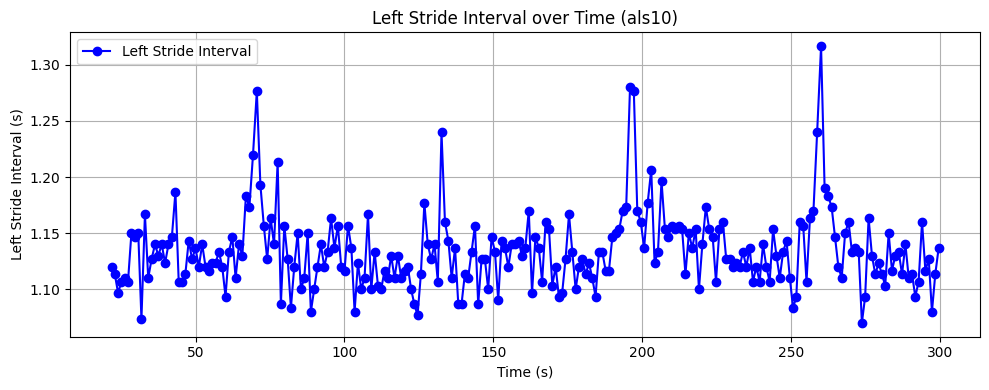

In [17]:
import matplotlib.pyplot as plt

# Choose a subject ID from data_dict
if not data_dict:
    print("Error: data_dict is empty. Cannot plot time series.")
else:
    try:
        subject_id = list(data_dict.keys())[1]  # Second subject, adjust as needed
        ts_data = data_dict[subject_id]["time_series"]
        
        # Validate L_Stride data
        if ts_data["L_Stride"].isnull().any() or not np.isfinite(ts_data["L_Stride"]).all():
            print(f"Error: Invalid or missing data in L_Stride for {subject_id}")
        else:
            # Plot Left Stride Interval vs Time
            plt.figure(figsize=(10, 4))
            plt.plot(ts_data["Time"], ts_data["L_Stride"], marker='o', linestyle='-', color='blue', label='Left Stride Interval')
            plt.xlabel("Time (s)")
            plt.ylabel("Left Stride Interval (s)")
            plt.title(f"Left Stride Interval over Time ({subject_id})")
            plt.grid(True)
            plt.legend()
            plt.tight_layout()
            plt.show()
    except (IndexError, KeyError) as e:
        print(f"Error selecting subject or accessing data: {e}")

In [25]:
# List all samples in data_dict
if not data_dict:
    print("Error: data_dict is empty. No samples to list.")
else:
    print(f"Listing all {len(data_dict)} samples in data_dict:")
    print(f"{'Subject ID':<15} {'Group':<10} {'In subject_info':<15}")
    print("-" * 40)
    # Sort by group and subject_id for readability
    sorted_samples = sorted(data_dict.items(), key=lambda x: (x[1]["group"], x[0]))
    for sid, record in sorted_samples:
        in_subject_info = "Yes" if sid in subject_info["Unnamed: 0"].values else "No"
        print(f"{sid:<15} {record['group']:<10} {in_subject_info:<15}")
    print(f"\nTotal samples: {len(data_dict)} (expected 64)")

Listing all 64 samples in data_dict:
Subject ID      Group      In subject_info
----------------------------------------
als1            als1       Yes            
als10           als1       Yes            
als11           als1       Yes            
als12           als1       Yes            
als13           als1       Yes            
als2            als2       Yes            
als3            als3       Yes            
als4            als4       Yes            
als5            als5       Yes            
als6            als6       Yes            
als7            als7       Yes            
als8            als8       Yes            
als9            als9       Yes            
control1        cont       Yes            
control10       cont       Yes            
control11       cont       Yes            
control12       cont       Yes            
control13       cont       Yes            
control14       cont       Yes            
control15       cont       Yes            
control16       con

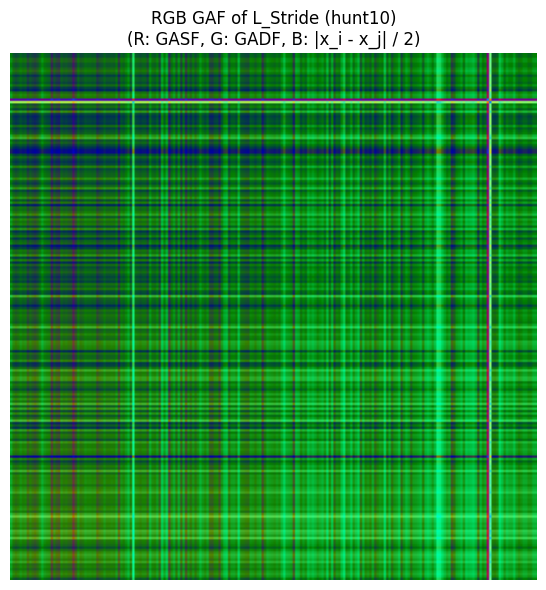

Generated RGB GAF for hunt10, L_Stride: shape=(220, 220, 3)


In [51]:
import numpy as np
import matplotlib.pyplot as plt
from pyts.image import GramianAngularField

# Apply RGB GAF transformation with meaningful blue channel
if not data_dict:
    print("Error: data_dict is empty. Cannot apply GAF.")
else:
    try:
        subject_id = "hunt10"  # Verify this ID; dataset uses als01–als13, may need als01
        column_name = "L_Stride"  # Generalizable: change to R_Stride, L_Swing, etc.
        ts_data = data_dict[subject_id]["time_series"]
        signal = ts_data[column_name].values
        
        # Check for valid data
        if signal.size == 0 or not np.isfinite(signal).all():
            print(f"Error: Invalid {column_name} data for {subject_id}")
        else:
            # Normalize to [-1, 1]
            if np.max(signal) != np.min(signal):
                signal_normalized = 2 * ((signal - np.min(signal)) / (np.max(signal) - np.min(signal))) - 1
            else:
                signal_normalized = np.zeros_like(signal)
                print(f"Warning: {column_name} for {subject_id} is constant, normalized to zeros")
            
            # Apply GASF
            gaf_sum = GramianAngularField(method='summation')
            gasf_image = gaf_sum.fit_transform([signal_normalized])[0]
            
            # Apply GADF
            gaf_diff = GramianAngularField(method='difference')
            gadf_image = gaf_diff.fit_transform([signal_normalized])[0]
            
            # Compute meaningful blue channel: absolute difference of normalized values
            n = len(signal_normalized)
            blue_channel = np.abs(signal_normalized[:, None] - signal_normalized[None, :]) / 2
            
            # Normalize GASF and GADF to [0, 1] for RGB
            gasf_norm = (gasf_image - gasf_image.min()) / (gasf_image.max() - gasf_image.min())
            gadf_norm = (gadf_image - gadf_image.min()) / (gadf_image.max() - gadf_image.min())
            
            # Create RGB image (Red: GASF, Green: GADF, Blue: absolute difference)
            rgb_image = np.zeros((gasf_image.shape[0], gasf_image.shape[1], 3))
            rgb_image[:, :, 0] = gasf_norm # Red channel: GASF
            rgb_image[:, :, 1] =  gadf_norm # Green channel: GADF
            rgb_image[:, :, 2] =   blue_channel # Blue channel: |x_i - x_j| / 2
            
            # Visualize RGB GAF image
            plt.figure(figsize=(6, 6))
            plt.imshow(rgb_image, origin='lower')
            plt.title(f"RGB GAF of {column_name} ({subject_id})\n(R: GASF, G: GADF, B: |x_i - x_j| / 2)")
            plt.axis('off')
            plt.tight_layout()
            plt.show()
            
            print(f"Generated RGB GAF for {subject_id}, {column_name}: shape={rgb_image.shape}")
    except (IndexError, KeyError) as e:
        print(f"Error selecting subject or accessing data: {e}")

In [39]:
# Display duration and verify feature consistency for each subject
if not data_dict:
    print("Error: data_dict is empty. No samples to analyze.")
else:
    print(f"Analyzing duration and feature consistency for {len(data_dict)} samples:")
    print(f"{'Subject ID':<15} {'Group':<10} {'Duration (s)':<15} {'Features Consistent':<20}")
    print("-" * 60)
    
    feature_columns = [
        "L_Stride", "R_Stride", "L_Swing", "R_Swing", "L_Swing%", "R_Swing%", 
        "L_Stance", "R_Stance", "L_Stance%", "R_Stance%", "DoubleSupport", "DoubleSupport%"
    ]
    
    for sid, record in sorted(data_dict.items(), key=lambda x: (x[1]["group"], x[0])):
        ts_data = record["time_series"]
        try:
            # Calculate duration from Time column
            duration = ts_data["Time"].max() - ts_data["Time"].min()
            
            # Check if all features have same number of data points as Time
            time_count = ts_data["Time"].count()
            consistent = all(ts_data[col].count() == time_count for col in feature_columns)
            
            print(f"{sid:<15} {record['group']:<10} {duration:<15.2f} {str(consistent):<20}")
        except Exception as e:
            print(f"Error processing {sid}: {e}")
    
    print(f"\nTotal samples analyzed: {len(data_dict)} (expected 64)")

Analyzing duration and feature consistency for 64 samples:
Subject ID      Group      Duration (s)    Features Consistent 
------------------------------------------------------------
als1            als1       250.64          True                
als10           als1       277.78          True                
als11           als1       277.11          True                
als12           als1       277.04          True                
als13           als1       276.72          True                
als2            als2       276.91          True                
als3            als3       276.95          True                
als4            als4       275.67          True                
als5            als5       266.96          True                
als6            als6       275.69          True                
als7            als7       275.92          True                
als8            als8       276.13          True                
als9            als9       276.45          True 